# Task 4- Random Circuits

## Contents

1. [Problem statement](#problem_statement)
2. [Solution](#solution_description)
3. [Bonus problem statement](#bonus_statement)
5. [First approach](#first_approach)
6. [Second approach](#second_approach)

## Problem statement
<a name="problem_statement"></a>
Design a function that generates a random quantum circuit by considering as parameters the number of qubits, the depth, and the base of gates to be used. You could only use the quantum gates of 1 and 2 qubits.


## Solution
<a name="solution_description"></a>
The algorithm imports the gates from `qiskit.circuit.library.standard_gates` and then recognizes them in the user's input. The gates are categorized by the number of qubits (one or two) and the number of parameters, up to four. Then, a random number generator with a seed generated in the algorithm is used to set the parameters for the gates and add them to the circuit. The resulting circuit includes random measurements, resets and conditionals.

For the first step, I import all the libraries and gates I will use.

In [18]:
!pip install pylatexenc
!pip install qiskit
from IPython.display import clear_output
clear_output()

In [14]:
from qiskit import QuantumCircuit, Aer, IBMQ, execute
from qiskit.transpiler import CouplingMap
from qiskit.compiler import transpile
from qiskit.visualization import *
import numpy as np
from qiskit.circuit import QuantumRegister, ClassicalRegister, QuantumCircuit, Reset
from qiskit.circuit.library.standard_gates import (IGate, U1Gate, U2Gate, U3Gate, XGate,
                                                YGate, ZGate, HGate, SGate, SdgGate, TGate,
                                                   TdgGate, RXGate, RYGate, RZGate, CXGate,
                                                   CYGate, CZGate, CHGate, CRZGate, CU1Gate,
                                                   CU3Gate, SwapGate, RZZGate, RYYGate,
                                                   RXXGate, CSwapGate, PhaseGate, DCXGate, 
                                                   CRXGate, CRYGate, CRZGate, CSXGate, CUGate,
                                                   RGate, RZXGate, CPhaseGate, CCXGate, XXMinusYYGate,
                                                   XXPlusYYGate, ECRGate, iSwapGate, SXGate, SXdgGate,
                                                   UGate)

from qiskit.circuit.exceptions import CircuitError
from qiskit.util import deprecate_arguments
from qiskit.compiler import transpile
from qiskit.visualization import plot_coupling_map
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor

Then, I define the function and get the gates the user wants to use. This step includes categorizing the gates as well. After that, building of the circuit itself begins with including random measurements, conditionals and resets and generating a seed to begin the generator for random values. Then, depending on their number for each gate, the parameters are generated, as well as the random choices of including each gate.

In [5]:
# define the function
@deprecate_arguments({'n_qubits': 'num_qubits'})
def random_circuit(num_qubits, depth, max_operands=2, measure=True,
                   conditional=True, reset=True, seed=None,
                   *, n_qubits=None):  
    
# gather user's options regarding gates
    one_q_ops=[eval(item) for item in input(
        '''Enter all the one-qubit gates you want to use. The options are:
        IGate    U1Gate    U2Gate    U3Gate  
        XGate    ZGate     HGate     SGate
        SdgGate  TGate     TdgGate   RXGate  
        RYGate   RZGate    PhaseGate RGate
        SXGate   SXdgGate  UGate
        
        '''
    ).split()]
    
    one_param = [U1Gate, RXGate, RYGate, RZGate, RZZGate, CU1Gate, CRZGate, PhaseGate,
                CPhaseGate, CRXGate, CRYGate, CRZGate, RZXGate, RXXGate, RYYGate]
    two_param= [U2Gate, RGate, XXPlusYYGate, XXMinusYYGate]
    three_param = [U3Gate, CU3Gate, UGate]
    four_param= [CUGate]
    two_q_ops = [eval(item) for item in input(
        '''Enter all the two-qubits gates you want to use. The options are:
        CXGate       CYGate      CZGate     CHGate  
        CU1Gate      CU3Gate     SwapGate   RZZGate
        DCXGate      CPhaseGate  CRXGate    CRYGate
        CRZGate      CSXGate     CUGate     RZXGate
        RZZGate      RXXGate     RYYGate    XXPlusYYGate
        XXPlusYYGate ECRGate     iSwapGate
        '''
    ).split()]
    
# build the circuit 
    qr = QuantumRegister(num_qubits, 'q')
    qc = QuantumCircuit(num_qubits)

    # insert middle conditionals and measurements   
    if measure or conditional:
        cr = ClassicalRegister(num_qubits, 'c')
        qc.add_register(cr)
    
    # insert middle resets
    if reset:
        one_q_ops += [Reset]
        
    # generate a seed to initialize the generation of random operations
    if seed is None:
        seed = np.random.randint(0, np.iinfo(np.int32).max)
    rng = np.random.default_rng(seed)

# apply random operations at every depth
    for _ in range(depth):
        remaining_qubits = list(range(num_qubits))
        while remaining_qubits:
            max_possible_operands = min(len(remaining_qubits), max_operands)
            num_operands = rng.choice(range(max_possible_operands)) + 1
            rng.shuffle(remaining_qubits)
            operands = remaining_qubits[:num_operands]
            remaining_qubits = [q for q in remaining_qubits if q not in operands]
            if num_operands == 1:
                operation = rng.choice(one_q_ops)
            elif num_operands == 2:
                operation = rng.choice(two_q_ops)
           
            if operation in one_param:
                num_angles = 1
            elif operation in two_param:
                num_angles = 2
            elif operation in three_param:
                num_angles = 3
            elif operation in four_param:
                num_angles = 4
            else:
                num_angles = 0
            angles = [rng.uniform(0, 2 * np.pi) for x in range(num_angles)]
            register_operands = [qr[i] for i in operands]
            op = operation(*angles)

            if conditional and rng.choice(range(10)) == 0:
                value = rng.integers(0, np.power(2, num_qubits))
                op.condition = (cr, value)

            qc.append(op, register_operands)
# add measurements at the end 
    if measure:
        qc.measure(qr, cr)

    return qc   

Now that I defined my function, I can call it. In this step, the user can set the number of qubits and the depth as well. The obtained circuit will then be drawn.

Enter the number of qubits:6
Enter the depth of the circuit:4
Enter all the one-qubit gates you want to use. The options are:
        IGate    U1Gate    U2Gate    U3Gate  
        XGate    ZGate     HGate     SGate
        SdgGate  TGate     TdgGate   RXGate  
        RYGate   RZGate    PhaseGate RGate
        SXGate   SXdgGate  UGate
        
        U2Gate PhaseGate RZGate
Enter all the two-qubits gates you want to use. The options are:
        CXGate       CYGate      CZGate     CHGate  
        CU1Gate      CU3Gate     SwapGate   RZZGate
        DCXGate      CPhaseGate  CRXGate    CRYGate
        CRZGate      CSXGate     CUGate     RZXGate
        RZZGate      RXXGate     RYYGate    XXPlusYYGate
        XXPlusYYGate ECRGate     iSwapGate
        XXPlusYYGate SwapGate CZGate


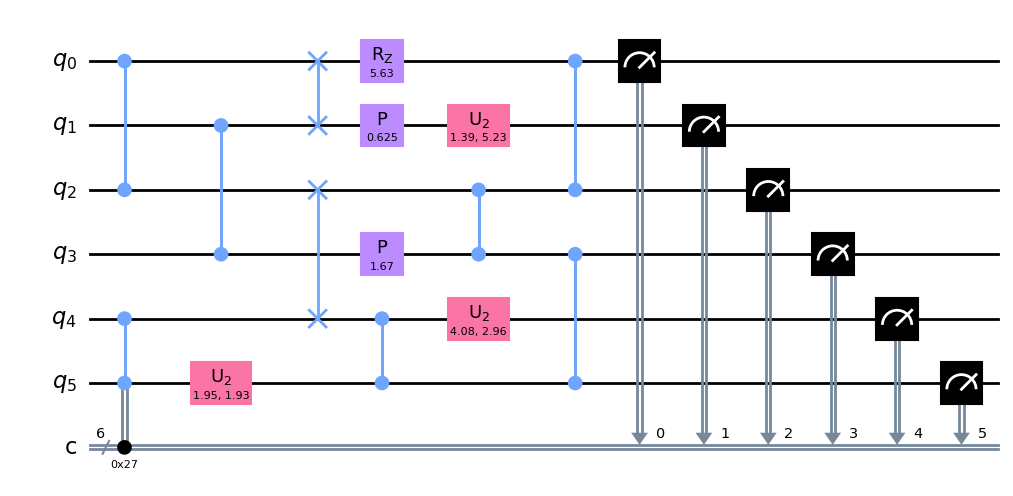

In [7]:
num_qubits= int(input("Enter the number of qubits:"))
depth=int(input("Enter the depth of the circuit:"))
circ = random_circuit(num_qubits, depth)
circ.draw(output='mpl')

## Bonus problem statement
<a name="bonus_statement"></a>

The bonus asks to do the same procedure, but with a given qubit array- this approach is useful because real quantum computers are not ideal and the arrangement of qubits has to be taken into account when designing a quantum circuit. The depth of a circuit is affected after the transpilation process. First of all, I created a Coupling Map in Qiskit for this array. The following code creates a list of qubit positions and the connections between them and creates a graph, just like in informatics, depicting the qubit arrangement.

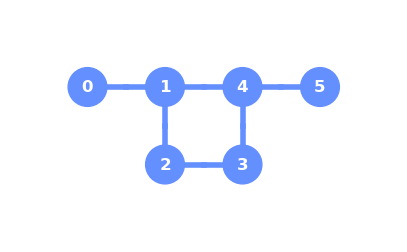

In [8]:
num_qubits = 6
qubit_coordinates = [[0, 0], [0, 1], [1, 1], [1, 2], [0, 2], [0, 3]]
coupling_map = [[0, 1], [1,0], [1,4], [4,1], [4,5], [5,4], [3,4], [4,3], [2,3], [3,2], [2,1], [1, 2]]
plot_coupling_map(num_qubits, qubit_coordinates, coupling_map)

## Solutions
<a name="solutions"></a>

### First approach
<a name="first_approach"></a>

In this first algorithm I added one more section to the previous code to take the generated circuit and transpile it, then communicate the final depth. This way, the user can experiment with different gates and see how using them changes the depth after the transpilation process. The more complex the gates, the bigger this difference. It also outputs an error message if more than 6 qubits are inputed.

Enter the number of qubits:6
Enter the depth of the circuit:4
Enter all the one-qubit gates you want to use. The options are:
        IGate    U1Gate    U2Gate    U3Gate  
        XGate    ZGate     HGate     SGate
        SdgGate  TGate     TdgGate   RXGate  
        RYGate   RZGate    PhaseGate RGate
        SXGate   SXdgGate  UGate
        
        TGate SXdgGate UGate
Enter all the two-qubits gates you want to use. The options are:
        CXGate       CYGate      CZGate     CHGate  
        CU1Gate      CU3Gate     SwapGate   RZZGate
        DCXGate      CPhaseGate  CRXGate    CRYGate
        CRZGate      CSXGate     CUGate     RZXGate
        RZZGate      RXXGate     RYYGate    XXPlusYYGate
        XXPlusYYGate ECRGate     iSwapGate
        CU1Gate CXGate
The transpiled circuit has a depth of: 5


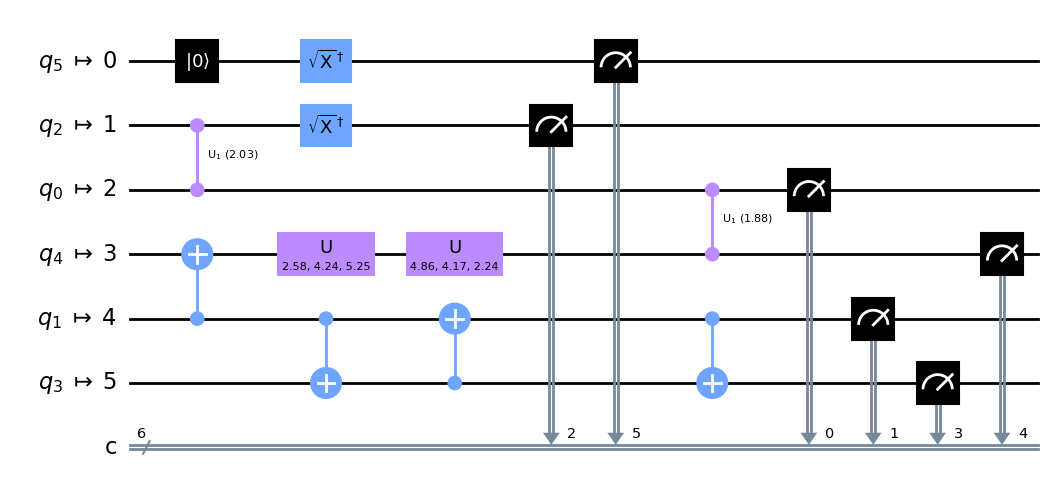

In [10]:
num_qubits= int(input("Enter the number of qubits:"))
if num_qubits > 6:
        raise CircuitError("The coupling map only contains 6 qubits")
        
depth=int(input("Enter the depth of the circuit:"))

circ = random_circuit(num_qubits, depth)
circ_transpiled=transpile(circ, coupling_map=coupling_map, optimization_level=2)
print("The transpiled circuit has a depth of:", circ_transpiled.depth())
circ_transpiled.draw(output='mpl')

### Second approach
<a name="second_approach"></a>

In this second algorithm, the user provides the desired final depth. It works like the one from the first approach, with the exception that it edits the final circuit to match the desired depth by dropping some layers from the circuit. The fact that the measurements are no longer included is not really a problem since the circuit is random anyway and does not have any constraints in this sense. At the end, it prints the final circuit.

Enter the number of qubits:5
Enter the depth of the circuit:5
Enter all the one-qubit gates you want to use. The options are:
        IGate    U1Gate    U2Gate    U3Gate  
        XGate    ZGate     HGate     SGate
        SdgGate  TGate     TdgGate   RXGate  
        RYGate   RZGate    PhaseGate RGate
        SXGate   SXdgGate  UGate
        
        SXGate PhaseGate UGate
Enter all the two-qubits gates you want to use. The options are:
        CXGate       CYGate      CZGate     CHGate  
        CU1Gate      CU3Gate     SwapGate   RZZGate
        DCXGate      CPhaseGate  CRXGate    CRYGate
        CRZGate      CSXGate     CUGate     RZXGate
        RZZGate      RXXGate     RYYGate    XXPlusYYGate
        XXPlusYYGate ECRGate     iSwapGate
        XXPlusYYGate CPhaseGate 


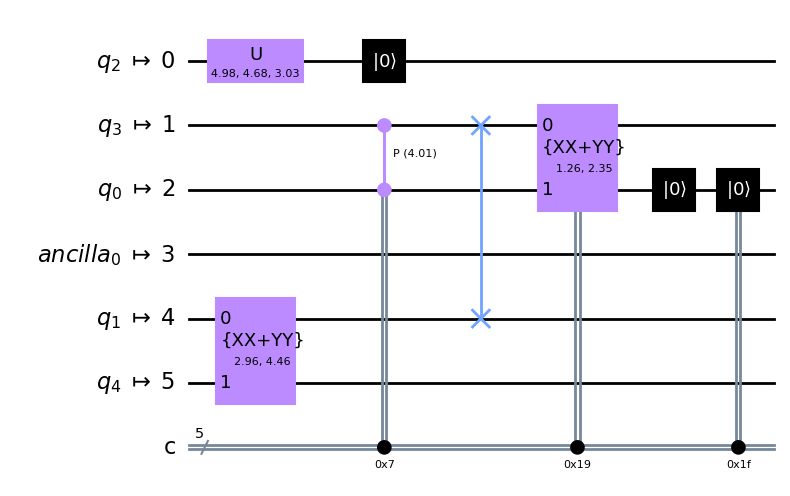

In [11]:
num_qubits= int(input("Enter the number of qubits:"))
if num_qubits > 6:
        raise CircuitError("The coupling map only contains 6 qubits")
        
depth=int(input("Enter the depth of the circuit:"))

circ = random_circuit(num_qubits, depth)
circ_transpiled=transpile(circ, coupling_map=coupling_map, optimization_level=2)
init=circ_transpiled.depth()

# edit the depth of the circuit by dropping layers
if init > depth:
        n = init - depth # number of layers to remove
        while circ_transpiled.depth() > depth:
            circ_transpiled.data.pop(-1)

circ_transpiled.draw(output='mpl')